In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# cd "/content/drive/MyDrive/"

**Helper Function**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from PIL import Image

import math
import json

In [3]:
def load_model(model, dataset_desc, epoch_num):
  path = './models/' + dataset_desc + '/' + dataset_desc + '_model_epoch_' + str(epoch_num).zfill(5) + '.pt'

  # check if the file exists
  if not os.path.exists(path):
    print("Incorrect filename")  
    return 

  # load the checkpoint file
  try: 
    checkpoint = torch.load(path)      
    model.load_state_dict(checkpoint['model_state_dict'])
  except: 
    print("Error in loading model")    

In [4]:
def load_stat(dataset_desc):
  accuracy_stats = {
      'train': [],
      "val": []
  }

  loss_stats = {
      'train': [],
      "val": []
  }

  # load the savedModel stat file
  stat_file_name = './models/' + dataset_desc + '/' + dataset_desc + '_stat.json'
  
  if os.path.isfile(stat_file_name):
    with open(stat_file_name, 'r') as f:
      try:
        model_stats = json.load(f)
        accuracy_stats = model_stats["accuracy"]
        loss_stats = model_stats["loss"]
      except:
        print("Error in loading model stat") 

  return accuracy_stats, loss_stats

In [5]:
# ResNext Reimplemented Model
def conv1x1(input, output, stride=1):
  return nn.Conv2d(input, output, kernel_size=1, stride=stride, bias=False)

def conv3x3(input, output, groups=1, padding=0, stride=1):
  return nn.Conv2d(input, output, kernel_size=3, groups=groups, padding=padding, stride=stride, bias=False)

class Bottleneck(nn.Module):
  def __init__(self, in_channel, mid_channel, out_channel, stride=1, downsample = None):
    super().__init__()

    self.conv1 = conv1x1(in_channel, mid_channel)
    self.bn1 = nn.BatchNorm2d(mid_channel)
    self.conv2 = conv3x3(mid_channel, mid_channel, groups=32, padding=1, stride=stride)
    self.bn2 = nn.BatchNorm2d(mid_channel)
    self.conv3 = conv1x1(mid_channel, out_channel)
    self.bn3 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity  # skip connection
    out = self.relu(out)

    return out

# Resnext50 reimplement
class resnext50_reimplement(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, dilation=1)
    self.layer1 = self._make_layer(1)
    self.layer2 = self._make_layer(2)
    self.layer3 = self._make_layer(3)
    self.layer4 = self._make_layer(4)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(2048, num_classes)
    self.softmax = nn.Softmax(dim=1)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d)):
          nn.init.ones_(m.weight)
          nn.init.zeros_(m.bias)

  def _make_layer(self, layer_num):
    layer_sizes = [3, 4, 6, 3]
    channel_sizes = [(64, 128, 256), (256, 256, 512), (512, 512, 1024), (1024, 1024, 2048)]

    # init stride for layer
    if layer_num == 1:
      stride = 1
    else:
      stride = 2

    # to fit to list position
    layer_num -=  1

    # downsample layer for residual connection
    downsample = nn.Sequential(
      conv1x1(channel_sizes[layer_num][0], channel_sizes[layer_num][2], stride=stride),
      nn.BatchNorm2d(channel_sizes[layer_num][2])
    )
    
    # generate first layer in each layer blocks
    layers = []
    layers.append(
        Bottleneck(channel_sizes[layer_num][0], channel_sizes[layer_num][1], channel_sizes[layer_num][2], stride=stride, downsample=downsample)
    )

    # generate the rest of the layers
    for _ in range(1, layer_sizes[layer_num]):
      layers.append(
          Bottleneck(channel_sizes[layer_num][2], channel_sizes[layer_num][1], channel_sizes[layer_num][2])
      )

    # return the layer block
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    #x = self.softmax(x)

    return x

# Resnext29 reimplement
class resnext29_reimplement(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=3, stride=2, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, dilation=1)
    self.layer1 = self._make_layer(1)
    self.layer2 = self._make_layer(2)
    self.layer3 = self._make_layer(3)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(1024, num_classes)
    self.softmax = nn.Softmax(dim=1)

    for m in self.modules():
      if isinstance(m, (nn.Conv2d, nn.Linear)):
          nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, (nn.BatchNorm2d)):
          nn.init.ones_(m.weight)
          nn.init.zeros_(m.bias)

  def _make_layer(self, layer_num):
    layer_sizes = [3, 3, 3]
    channel_sizes = [(64, 64, 256), (256, 256, 512), (512, 512, 1024)]

    # init stride for layer
    if layer_num == 1:
      stride = 1
    else:
      stride = 2

    # to fit to list position
    layer_num -=  1

    # downsample layer for residual connection
    downsample = nn.Sequential(
      conv1x1(channel_sizes[layer_num][0], channel_sizes[layer_num][2], stride=stride),
      nn.BatchNorm2d(channel_sizes[layer_num][2])
    )
    
    # generate first layer in each layer blocks
    layers = []
    layers.append(
        Bottleneck(channel_sizes[layer_num][0], channel_sizes[layer_num][1], channel_sizes[layer_num][2], stride=stride, downsample=downsample)
    )

    # generate the rest of the layers
    for _ in range(1, layer_sizes[layer_num]):
      layers.append(
          Bottleneck(channel_sizes[layer_num][2], channel_sizes[layer_num][1], channel_sizes[layer_num][2])
      )

    # return the layer block
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    #x = self.softmax(x)

    return x

In [6]:
#@title
# Random model for debug
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(3, 256, kernel_size=3, bias=False)
    self.bn1 = nn.BatchNorm2d(256)

    self.conv2 = nn.Conv2d(256, 256, kernel_size=3, bias=False)
    self.bn2 = nn.BatchNorm2d(256)

    self.conv3 = nn.Conv2d(256, 512, kernel_size=3, bias=False)
    self.bn3 = nn.BatchNorm2d(512)

    self.conv4 = nn.Conv2d(512, 512, kernel_size=3, bias=False)
    self.bn4 = nn.BatchNorm2d(512)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)

    x = self.conv4(x)
    x = self.bn4(x)
    x = self.relu(x)
    
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
  
    return x

In [7]:
# Create the model
# define a model
random_model = Net()

# define reimplement model
pikachu_resnext50_reimplement_model = resnext50_reimplement(num_classes=2)
cifar10_resnext29_reimplement_model = resnext29_reimplement(num_classes=10)

import torchvision.models as models

# build the network for pikachu
pikachu_resnext50_model = models.resnext50_32x4d()
in_c = pikachu_resnext50_model.fc.in_features
pikachu_resnext50_model.fc = nn.Linear(in_c, 2)

pikachu_resnet18_model = models.resnet18()
in_c = pikachu_resnet18_model.fc.in_features
pikachu_resnet18_model.fc = nn.Linear(in_c, 2)

# build the network for CIFAR-10
cifar10_resnet18_model = models.resnet18()
in_c = cifar10_resnet18_model.fc.in_features
cifar10_resnet18_model.fc = nn.Linear(in_c, 10)


**View Stat**

Modify the selected_num value to select over different stat of model

0 - ResNext29 reimplementation cifar10 <br>
1 - ResNet18 cifar10 <br>
2 - Random model for pikachu dataset <br>
3 - ResNet18 for pikachu dataset <br>
4 - ResNext50 for pikachu dataset <br>
5 - ResNext50 Reimplementation for pikachu dataset <br>

In [8]:
dataset_desc = [
                'cifar10_dataset', 
                'resnet_cifar10_dataset', 
                'random_model_pikachu_dataset',
                'resnet18_pikachu_dataset',
                'resnext50_pikachu_dataset',
                'resnext50_reimplementation_pikachu_dataset'
                ]

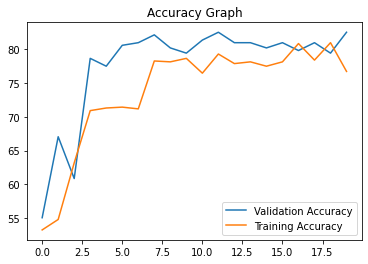

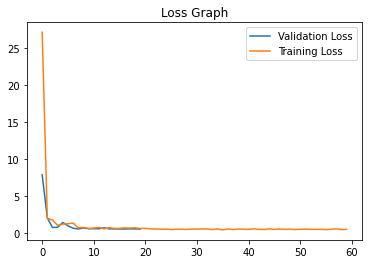

In [9]:
# To view stat for the specific model
# Modify the value of selected_num to select the model
selected_num = 5
accuracy_stat, loss_stat = load_stat(dataset_desc[selected_num])

# Plot Accuracy Graph
plt.title("Accuracy Graph")
plt.plot(accuracy_stat["val"], label='Validation Accuracy')
plt.plot(accuracy_stat["train"], label='Training Accuracy')
plt.legend()
plt.show()

# Plot Loss Graph
plt.title("Loss Graph")
plt.plot(loss_stat["val"], label='Validation Loss')
plt.plot(loss_stat["train"], label='Training Loss')
plt.legend()
plt.show()

**Run the model**

In [10]:
# Helper Function to test the model
# type - pikachu, cifar10

def test_model(model, image_path="pikachu.jpg", type="pikachu"):
  # Preprocess the image
  image = Image.open(image_path).convert('RGB')
  
  # Set model for evaluation mode
  model.eval()
    
  if type == "pikachu":
    transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    classes = ['not_pikachu', 'pikachu']
    
  elif type == "cifar10":
    transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
  else:
    print("Invalid type")
    return

  image_tensor = transform(image)
  image_tensor = image_tensor[np.newaxis, :] 

  outs = model(image_tensor)
  _, result = torch.max(outs, 1)

  print(f"The image is {classes[result]}")


In [12]:
# Select one of the model in below to run
# To run another model copy the desired model from below, replace the parameter of load model function
# The epoch num start with 0

###################################################
# cifar10_resnext29_reimplement_model, dataset_desc[0], epoch_num=62
# cifar10_resnet18_model, dataset_desc[1], epoch_num=101
# random_model, dataset_desc[2], epoch_num=9
# pikachu_resnet18_model, dataset_desc[3], epoch_num=19
# pikachu_resnext50_model, dataset_desc[4], epoch_num=19
# pikachu_resnext50_reimplement_model, dataset_desc[5], epoch_num=19
###################################################

# load_model(cifar10_resnext29_reimplement_model, dataset_desc[0], epoch_num=62)
# load_model(cifar10_resnet18_model, dataset_desc[1], epoch_num=101)
# load_model(random_model, dataset_desc[2], epoch_num=9)
# load_model(pikachu_resnet18_model, dataset_desc[3], epoch_num=19)
# load_model(pikachu_resnext50_model, dataset_desc[4], epoch_num=19)
load_model(pikachu_resnext50_reimplement_model, dataset_desc[5], epoch_num=19)

# To test with your own image, just copy the image into same directory with this file
# and change the image path parameter to your filename
test_model(pikachu_resnext50_reimplement_model, "pikachu.jpg")
# test_model(pikachu_resnext50_model, "dog.jpg", type="cifar10")

The image is pikachu
